## Preamble, Set Up and Data Cleaning

In [68]:
import qgrid
qgrid.set_grid_option('forceFitColumns', False)
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
df = pd.read_csv('/Users/enochosei/Library/Mobile Documents/com~apple~CloudDocs/Data Science/unicorn_startup_companies (1).csv')

In [70]:
# qgrid.show_grid(df)

In [71]:
df.head()

,Unnamed: 0,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Investors
0,0,ByteDance,$225,4/7/2017,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S..."
1,1,SpaceX,$137,12/1/2012,United States,Hawthorne,Industrials,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,2,SHEIN,$66,7/3/2018,China,Shenzhen,Consumer & Retail,"Tiger Global Management, Sequoia Capital China..."
3,3,Stripe,$50,1/23/2014,United States,San Francisco,Financial Services,"Khosla Ventures, LowercaseCapital, capitalG"
4,4,Canva,$40,1/8/2018,Australia,Surry Hills,Enterprise Tech,"Sequoia Capital China, Blackbird Ventures, Mat..."


In [72]:
print(df.columns)

Index(['Unnamed: 0', 'Company', 'Valuation ($B)', 'Date Joined', 'Country',
       'City', 'Industry', 'Select Investors'],
      dtype='object')


In [73]:
# Drop Unnecessary Column 
df = df.drop("Unnamed: 0", axis=1)

In [74]:
# Check column datatypes
df.dtypes

Company             object
Valuation ($B)      object
Date Joined         object
Country             object
City                object
Industry            object
Select Investors    object
dtype: object

In [75]:
# Convert relevant columns to workable types
df['Valuation ($B)'] = df['Valuation ($B)'].str.replace('$', '').astype(float)
df['Date Joined'] = pd.to_datetime(df['Date Joined'])

/var/folders/qm/41v4pccs7bz2kwmbyfkprfgr0000gn/T/ipykernel_31082/3865639692.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Valuation ($B)'] = df['Valuation ($B)'].str.replace('$', '').astype(float)


In [76]:
# Confirm dtype changes  
df.dtypes

Company                     object
Valuation ($B)             float64
Date Joined         datetime64[ns]
Country                     object
City                        object
Industry                    object
Select Investors            object
dtype: object

In [77]:
# Get standardized 3 character country codes 
import pycountry

In [78]:
# Create a mapping of country names to country codes
mapping = {country.name: country.alpha_3 for country in pycountry.countries}

# Apply the mapping to your data frame column
df['Country Code'] = df['Country'].apply(lambda x: mapping.get(x))

In [79]:
# Countries where the mapping failed
df[df['Country Code'].isnull()]['Country']

91         South Korea
189        South Korea
262        South Korea
303            Vietnam
334        South Korea
393        South Korea
401            Vietnam
407        South Korea
517        South Korea
531        South Korea
718        South Korea
742        South Korea
744        South Korea
825     Czech Republic
851        South Korea
1017       South Korea
1065            London
1138       South Korea
Name: Country, dtype: object

In [80]:
# Apply the fuzzy search to fill the missing countries (takes a minute to run)
df['Country Code'] = df['Country Code'].fillna(df['Country'].apply(lambda x: pycountry.countries.search_fuzzy(x)[0].alpha_3))

In [81]:
# Check if fuzzy mapping worked (should return and empty list)
df[df['Country Code'].isnull()]['Country']

Series([], Name: Country, dtype: object)

## Data Starting Point

In [82]:
# qgrid.show_grid(df)

In [83]:
df.head()

,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Investors,Country Code
0,ByteDance,225.0,2017-04-07,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S...",CHN
1,SpaceX,137.0,2012-12-01,United States,Hawthorne,Industrials,"Founders Fund, Draper Fisher Jurvetson, Rothen...",USA
2,SHEIN,66.0,2018-07-03,China,Shenzhen,Consumer & Retail,"Tiger Global Management, Sequoia Capital China...",CHN
3,Stripe,50.0,2014-01-23,United States,San Francisco,Financial Services,"Khosla Ventures, LowercaseCapital, capitalG",USA
4,Canva,40.0,2018-01-08,Australia,Surry Hills,Enterprise Tech,"Sequoia Capital China, Blackbird Ventures, Mat...",AUS


## Feature Engineering and Data Enrichment


In [84]:
# Calculating the no of days since the company became a 'Unicorn'

df['Date Since Joined'] = (pd.to_datetime('today') - df['Date Joined']).dt.days
df = df.reindex(columns=['Date Joined', 'Date Since Joined'] + list(df.columns.drop(['Date Joined', 'Date Since Joined'])))

In [85]:
# Sub-designating a unicorns as 'Decacorns' and 'Hectocorns'

df['Decacorn'] = (df['Valuation ($B)'] >= 10).astype(int)
df['Hectocorn'] = (df['Valuation ($B)'] >= 100).astype(int)

In [86]:
df.columns

Index(['Date Joined', 'Date Since Joined', 'Company', 'Valuation ($B)',
       'Country', 'City', 'Industry', 'Select Investors', 'Country Code',
       'Decacorn', 'Hectocorn'],
      dtype='object')

### Adding Macro Variables to the Data Set

#### Adding Macro data from the World Bank API

In [87]:
import pandas_datareader.data as web
import wbdata
from datetime import datetime
import wbgapi as wb

In [88]:
#Make a list of the country codes in the data
country_codes = df['Country Code'].tolist()
distinct_codes = set(country_codes)
distinct_codes = list(distinct_codes)
# distinct_codes.remove(None)
print(distinct_codes)

['IRL', 'MYS', 'HKG', 'CAN', 'GRC', 'ITA', 'LIE', 'USA', 'PHL', 'FIN', 'AUS', 'CHL', 'NLD', 'ARE', 'MEX', 'ECU', 'TUR', 'GBR', 'IDN', 'LUX', 'HRV', 'IND', 'SGP', 'AUT', 'ZAF', 'SWE', 'BRA', 'SEN', 'KOR', 'ESP', 'FRA', 'DEU', 'THA', 'ARG', 'NGA', 'CZE', 'BEL', 'SYC', 'BMU', 'COL', 'NOR', 'CHE', 'CHN', 'EST', 'LTU', 'EGY', 'ISR', 'JPN', 'DNK', 'VNM']


In [89]:
# Test World Bank Data Extraction

# Test list of countries
countries = ["USA", "CAN", "MEX"]

# Create a list of indicators


indicators_per_cap = {"NY.GDP.PCAP.CD": "Current GDP per capita"}

# Create a list of indicators
indicators = {"NY.GDP.MKTP.CD": "GDP", "FR.INR.LEND": "Lending interest rate", "FP.CPI.TOTL.ZG": "Inflation rate", "IC.TAX.TOTL.CP.ZS": "Corporation tax"}


past_indicators = {"NY.GDP.MKTP.CD": "GDP"}
past_indicators_per_cap = {"NY.GDP.PCAP.CD": "GDP per capita"}

data_date = datetime.strptime("2022", "%Y")

# Get the data for the most recent year available
df2 =  wbdata.get_dataframe(indicators, country=countries,data_date=data_date, keep_levels=True)

print(df2.head())

                             GDP  Lending interest rate  Inflation rate  \
country       date                                                        
Canada        2022  2.139840e+12                    NaN        6.802801   
Mexico        2022  1.414187e+12               8.179167        7.896276   
United States 2022  2.546270e+13                    NaN        8.002800   

                   Corporation tax  
country       date                  
Canada        2022            None  
Mexico        2022            None  
United States 2022            None  


In [90]:
#Define relevant time period for GDP data 
prev_years = (datetime(2006, 1, 1), datetime(2022,1, 1))

In [91]:
#Dataframe for of Macro variables

df3 = wbdata.get_dataframe(indicators, country=distinct_codes, data_date=prev_years, keep_levels=True)

#Dataframe for per-capita GDP (Unused from henceforth)
df4 = wbdata.get_dataframe(past_indicators_per_cap, country=distinct_codes, data_date=prev_years, keep_levels=True)

JSONDecodeError: Expecting value: line 2 column 9 (char 9)

In [66]:
df2.sample(5)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [67]:
# Attach Country Codes to the Dataframe of Macro data using the country column

df2 = pd.DataFrame(df2)
df2['Country Code'] = df2.index.map(lambda x: mapping.get(x[0]))

In [ ]:
df2.columns, df2.dtypes

In [ ]:
# Pivot the dataframe
df2 = df2.reset_index()
df2 = df2.pivot(index='country', columns='date', values=['GDP', 'Lending interest rate', 'Inflation rate', 'Corporation tax'])

In [ ]:
df2.head()

In [ ]:
#Attatch the country code column
df2['Country Code'] = df2.index.map(mapping)

In [ ]:
# Identify countries with no country code
df2[df2['Country Code'].isnull()].index

In [ ]:
#Manually fill the missing country codes
df2['Country Code'] = df2['Country Code'].fillna({'Egypt, Arab Rep.': 'EGY', 'Hong Kong SAR, China': 'HKG', 'Korea, Rep.': 'KOR', 'Turkiye': 'TUR', 'Vietnam': 'VNM'})

In [ ]:
df2.sample(10)

In [ ]:
# Format the column names properly
new_columns = [(str(col).replace("'", '').strip('()')) for col in df2.columns if col != 'Country Code']
df2.columns = new_columns

In [ ]:
df2.head()

In [ ]:
# Creating GDP Growth Percentage Variables and Mean Growth Across the Years
gdp_columns = [col for col in df2.columns if 'GDP' in col]
df2_growth = (df2[gdp_columns].pct_change(axis=1))*100
df2_growth = df2_growth.assign(Mean_GDP_Growth = df2_growth.mean(axis=1), Variance_GDP_Growth = df2_growth.var(axis=1))

In [ ]:
#Join growth dataframe to absolute dataframe
df2 = df2.join(df2_growth, rsuffix=' Growth')

In [ ]:
#Create Columns for the mean values across the years 

lending_columns = [col for col in df2.columns if 'Lending interest rate' in col]
inflation_columns = [col for col in df2.columns if 'Inflation rate' in col]
tax_columns = [col for col in df2.columns if 'Corporation tax' in col]

df2['Mean_Lending_Rate'] = df2[lending_columns].mean(axis=1)
df2['Mean_Inflation_Rate'] = df2[inflation_columns].mean(axis=1)
df2['Mean_Corporation_Tax_Rate'] = df2[tax_columns].mean(axis=1)


In [ ]:
df2 = df2.rename(columns={'Country Code, ': 'Country Code'})

In [ ]:
# Identify countries with null values in the mean macro variables

lending_nulls = df2['Mean_Lending_Rate'].isnull()
inflation_nulls = df2['Mean_Inflation_Rate'].isnull()
tax_nulls = df2['Mean_Corporation_Tax_Rate'].isnull()

countries_with_lending_nulls = df2.index[lending_nulls]
countries_with_inflation_nulls = df2.index[inflation_nulls]
countries_with_tax_nulls = df2.index[tax_nulls]

print('Countries with null values for mean lending rate:')
print(countries_with_lending_nulls)
print('Countries with null values for mean inflation rate:')
print(countries_with_inflation_nulls)
print('Countries with null values for mean corporation tax rate:')
print(countries_with_tax_nulls)


In [ ]:
# df3.head()

In [ ]:
# Using the current values of the relevant Macro variables as proxies for those with missing values in lieu of the missing means. 

df2.index = df2.index.astype(str)

current_lending_rate = {'Austria': 1.5, 'Belgium': 1.5, 'Bermuda': 4.5, 'Denmark': 0.5, 'Ecuador': 10.2, 'Estonia': 2.5, 'Finland': 1.5, 'France': 1.5, 'Germany': 1.5, 'Greece': 4.3, 'Ireland': 2.3, 'Liechtenstein': 2.0, 'Lithuania': 2.5, 'Luxembourg': 1.5, 'Spain': 2.0, 'Turkiye': 18.0, 'United Arab Emirates': 4.0}
current_inflation_rate = {'Argentina': 51.8, 'Bermuda': 1.8, 'Liechtenstein': -0.6}
current_tax_rate = {'Bermuda': 0}

df2.fillna({'Mean_Lending_Rate': current_lending_rate, 'Mean_Inflation_Rate': current_inflation_rate, 'Mean_Corporation_Tax_Rate': current_tax_rate})


In [ ]:
# Merge Original Dataframe with the Macro data

df = pd.merge(df, df2, on='Country Code', how='left')

In [ ]:
# Display the Macro Data enriched Dataframe 

# qgrid.show_grid(df)

df.head()

In [ ]:
# df.columns.tolist()

## Descriptive Statistics and Data Exploration

In [ ]:
# # Group by country
# grouped = df.groupby("Country")

# # View the number of unicorns per country
# grouped.size().sample(8)

In [ ]:
# Show the countries with the highest number of unicorns
df_grouped = df.groupby("Country").size().reset_index(name="Unicorns")
df_grouped = df_grouped.sort_values(by="Unicorns", ascending=False)

In [ ]:
df_grouped

In [ ]:
# Create a new dataframe with only top 10 countries
df_top10 = df_grouped.head(10)

# Calculate the sum of unicorns for non top 10 countries
others = df_grouped.tail(-10)["Unicorns"].sum()

# Append a new row with label "others" and sum of unicorns
df_top10 = df_top10.append({"Country": "Others", "Unicorns": others}, ignore_index=True)

# View the new dataframe
# qgrid.show_grid(df_top10)
df_top10

In [ ]:
import plotly.express as px
fig = px.bar(df_top10, x="Country", y="Unicorns", color="Unicorns", hover_name="Country", color_continuous_scale=px.colors.sequential.tempo, title = 'Top 10 Countries by Number of Unicorns')
fig.show()

# Save plot
fig.write_image("Top 10 Countries by Number of Unicorns.png", width=800, height=600)

In [277]:
fig = px.choropleth(df_grouped, locations="Country", locationmode="country names", color="Unicorns", hover_name="Country", color_continuous_scale=px.colors.sequential.tempo, range_color=(0, 300), title = 'World Map of Unicorns')
fig.show()

In [59]:
# Group by country
grouped_city = df.groupby("City")

# View the number of unicorns per country
grouped_city.size().head()

City
Aarhus        1
Aberdeen      1
Alameda       1
Alexandria    1
Altrincham    1
dtype: int64

In [279]:
# Show the cities with the highest number of unicorns

df_grouped_city = grouped_city.size().reset_index(name="Unicorns")
df_grouped_city = df_grouped_city.sort_values(by="Unicorns", ascending=False)
qgrid.show_grid(df_grouped_city)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [61]:
# Create a new dataframe with only top 10 countries
df_top10_cities = df_grouped_city.head(10)

# View the new dataframe
qgrid.show_grid(df_top10_cities)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [280]:
fig = px.bar(df_top10_cities, x="City", y="Unicorns", color="Unicorns", hover_name="City", color_continuous_scale=px.colors.sequential.matter,title = 'Top 10 Cities by Number of Unicorns')
fig.show()

In [65]:
# df.to_excel("Unicornsdata.xlsx", index=False)

In [284]:
df.columns.to_list()

['Company',
 'Valuation ($B)',
 'Date Joined',
 'Country',
 'City',
 'Industry',
 'Select Investors',
 'Country Code',
 'GDP, 2006',
 'GDP, 2007',
 'GDP, 2008',
 'GDP, 2009',
 'GDP, 2010',
 'GDP, 2011',
 'GDP, 2012',
 'GDP, 2013',
 'GDP, 2014',
 'GDP, 2015',
 'GDP, 2016',
 'GDP, 2017',
 'GDP, 2018',
 'GDP, 2019',
 'GDP, 2020',
 'GDP, 2021',
 'GDP, 2022',
 'Lending interest rate, 2006',
 'Lending interest rate, 2007',
 'Lending interest rate, 2008',
 'Lending interest rate, 2009',
 'Lending interest rate, 2010',
 'Lending interest rate, 2011',
 'Lending interest rate, 2012',
 'Lending interest rate, 2013',
 'Lending interest rate, 2014',
 'Lending interest rate, 2015',
 'Lending interest rate, 2016',
 'Lending interest rate, 2017',
 'Lending interest rate, 2018',
 'Lending interest rate, 2019',
 'Lending interest rate, 2020',
 'Lending interest rate, 2021',
 'Lending interest rate, 2022',
 'Inflation rate, 2006',
 'Inflation rate, 2007',
 'Inflation rate, 2008',
 'Inflation rate, 2009',

In [289]:
# The proportion of Centicorns and Hectocorns
from pywaffle import Waffle

proportion_hectocorn = df['Hectocorn'].sum() / (len(df) - df['Hectocorn'].sum())
proportion_decacorn = df['Decacorn'].sum() / (len(df) - df['Decacorn'].sum())


print(f'The proportion of decacorns to all non decacorns is {proportion_decacorn * 100:.2f}%')
print(f'The proportion of hectocorns to all non hectocorns is {proportion_hectocorn * 100:.2f}%')

The proportion of decacorns to all non decacorns is 4.45%
The proportion of hectocorns to all non hectocorns is 0.16%


In [290]:
values_decacorn = [df['Decacorn'].sum() * 100, (len(df) - df['Decacorn'].sum()) * 100]
labels_decacorn = ['Decacorn', 'Non Decacorn']
values_hectocorn = [df['Hectocorn'].sum() * 100, (len(df) - df['Hectocorn'].sum()) * 100]
labels_hectocorn = ['Hectocorn', 'Non Hectocorn']

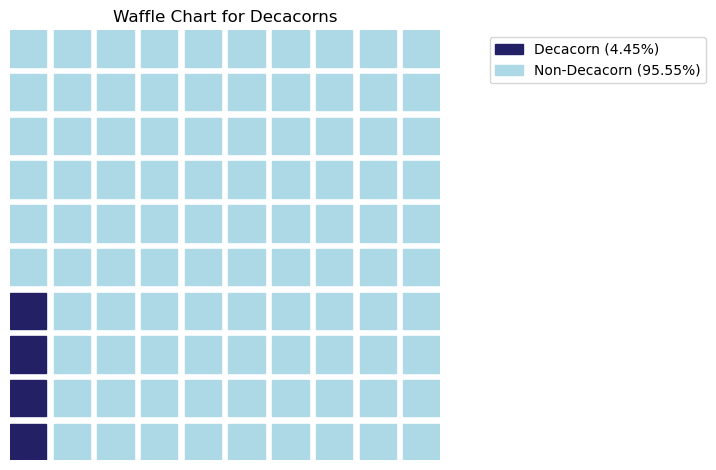

In [283]:
# Create a waffle chart for decacorns
data = {'Decacorn': proportion_decacorn * 100, 'Non-Decacorn': (1 - proportion_decacorn) * 100}
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns = 10,
    values=data,
    colors=["#232066", "#ADD8E6"],
    title={'label': 'Waffle Chart for Decacorns', 'loc': 'center'},
    labels=[f"{k} ({v:.2f}%)" for k, v in data.items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)},
    starting_location='SW',
    block_arranging_style='snake'
)
# fig.set_facecolor('#EEEEEE')
plt.show()

In [291]:
# Time plot of when the unicorns where founded 

import plotly.graph_objects as go

df['Year Joined'] = df['Date Joined'].dt.year

# Count the number of unicorns by year
df_count = df.groupby('Year Joined').size().reset_index(name='Number of Unicorns')
fig = px.bar(data_frame=df_count, x='Year Joined', y='Number of Unicorns', labels={'Year Joined':'Year', 'Number of Unicorns':'Count'}).update_layout(title='Number of Unicorns by Year', title_x=0.5).update_xaxes(dtick=1)
fig.add_trace(go.Scatter(x=df_count['Year Joined'], y=df_count['Number of Unicorns'], name='Number of Unicorns', mode='lines'))
fig.show()

In [292]:
# Count the number of unicorns by industry
df_industry = df['Industry'].value_counts().reset_index(name='Number of Unicorns')

# Make a bar chart using plotly
fig = px.bar(data_frame=df_industry, x='index', y='Number of Unicorns', labels={'index':'Industry', 'Number of Unicorns':'Number of Unicorns'}, title='Number of Unicorns by Industry').update_layout(title='Number of Unicorns by Industry', title_x=0.5)
fig.show()

In [73]:
df_industry

,index,Number of Unicorns
0,Enterprise Tech,370
1,Financial Services,216
2,Consumer & Retail,215
3,Industrials,190
4,Healthcare & Life Sciences,122
5,Media & Entertainment,81
6,Insurance,27


In [293]:
# Find the index of the sector with the largest value
max_index = df_industry['Number of Unicorns'].idxmax()

# Make a list of pull values
pull_values = [0.1 if i == max_index else 0 for i in range(len(df_industry))]

# Make a donut chart using plotly
fig = go.Figure(data=[go.Pie(labels=df_industry['index'], values=df_industry['Number of Unicorns'], hole=0.4, textinfo='label+percent', textposition='outside', pull=pull_values)])
# Add the total number of unicorns in the center
fig.update_layout(annotations=[dict(text='Total: {}'.format(df_industry['Number of Unicorns'].sum()), x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

### Unicorn Investor Analysis

In [75]:
# Split the df['Select Investors'] column into multiple rows using ', ' as the separator
df_investor = df.assign(Investor=df['Select Investors'].str.split(', ')).explode('Investor')

In [76]:
df_investor

,Date Joined,Date Since Joined,Company,Valuation ($B),Country,City,Industry,Select Investors,Country Code,Decacorn,...,"GDP, 2020 Growth","GDP, 2021 Growth","GDP, 2022 Growth",Mean_GDP_Growth,Variance_GDP_Growth,Mean_Lending_Rate,Mean_Inflation_Rate,Mean_Corporation_Tax_Rate,Year Joined,Investor
0,2017-04-07,2342,ByteDance,225.0,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S...",CHN,1,...,2.855574,21.328775,0.800828,12.800046,88.474618,5.234118,2.525466,66.171429,2017,Sequoia Capital China
0,2017-04-07,2342,ByteDance,225.0,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S...",CHN,1,...,2.855574,21.328775,0.800828,12.800046,88.474618,5.234118,2.525466,66.171429,2017,SIG Asia Investments
0,2017-04-07,2342,ByteDance,225.0,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S...",CHN,1,...,2.855574,21.328775,0.800828,12.800046,88.474618,5.234118,2.525466,66.171429,2017,Sina Weibo
0,2017-04-07,2342,ByteDance,225.0,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S...",CHN,1,...,2.855574,21.328775,0.800828,12.800046,88.474618,5.234118,2.525466,66.171429,2017,SoftBank Group
1,2012-12-01,3930,SpaceX,137.0,United States,Hawthorne,Industrials,"Founders Fund, Draper Fisher Jurvetson, Rothen...",USA,1,...,-1.499008,10.705395,9.211289,3.939294,9.775328,4.277760,2.424400,42.814286,2012,Founders Fund
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,2022-07-12,420,SingleStore,1.0,United States,San Francisco,Enterprise Tech,"Google Ventures, Accel, Data Collective",USA,0,...,-1.499008,10.705395,9.211289,3.939294,9.775328,4.277760,2.424400,42.814286,2022,Accel
1219,2022-07-12,420,SingleStore,1.0,United States,San Francisco,Enterprise Tech,"Google Ventures, Accel, Data Collective",USA,0,...,-1.499008,10.705395,9.211289,3.939294,9.775328,4.277760,2.424400,42.814286,2022,Data Collective
1220,2022-07-27,405,Unstoppable Domains,1.0,United States,Las Vegas,Media & Entertainment,"Boost VC, Draper Associates, Gaingels",USA,0,...,-1.499008,10.705395,9.211289,3.939294,9.775328,4.277760,2.424400,42.814286,2022,Boost VC
1220,2022-07-27,405,Unstoppable Domains,1.0,United States,Las Vegas,Media & Entertainment,"Boost VC, Draper Associates, Gaingels",USA,0,...,-1.499008,10.705395,9.211289,3.939294,9.775328,4.277760,2.424400,42.814286,2022,Draper Associates


In [77]:
# Group by the investor column and apply aggregation functions
df_summary = df_investor.groupby('Investor').agg(
    Number_of_Unicorns = ('Company', 'nunique'),
    Names_of_Unicorns = ('Company', lambda x: ', '.join(x.unique())),
    Countries_of_Unicorns = ('Country', lambda x: ', '.join(x.unique())),
    Sum_of_Valuations = ('Valuation ($B)', 'sum')
)

# Display or export the final dataframe
df_summary

,Number_of_Unicorns,Names_of_Unicorns,Countries_of_Unicorns,Sum_of_Valuations
Investor,,,,
.406 Ventures,1,Reltio,United States,1.70
01 Advisors,2,"Tipalti, Density",United States,9.35
01 Advisors. Kleiner Perkins Caufield & Byers. Andreessen Horowitz,1,Autograph,United States,3.66
10T Fund,2,"Gemini, Babel Finance","United States, Hong Kong",9.10
14W,2,"Fever, K Health",United States,3.46
...,...,...,...,...
iTech Capital,1,BitFury,Netherlands,1.00
iVision Ventures,1,Keenon Robotics,China,1.00
kt investment,1,MEGAZONE,South Korea,1.83


In [78]:
qgrid.show_grid(df_summary)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [79]:
# Group by investor and company and get max valuation
df_max_valuation = df_investor.groupby(['Investor', 'Company'])['Valuation ($B)'].max().reset_index()

# Sort by valuation and drop duplicates by investor
df_max_valuation = df_max_valuation.sort_values(by='Valuation ($B)', ascending=False).drop_duplicates(subset='Investor')

# Rename columns and reset index
df_max_valuation.columns = ['Investor', 'Most Valuable Unicorn', 'Valuation of Most Valuable Unicorn ($B)']
df_max_valuation = df_max_valuation.reset_index(drop=True)

# Join with df_summary
df_summary = df_summary.join(df_max_valuation.set_index('Investor'), on='Investor')

# Group by investor and country and get count of unicorns
df_country_count = df_investor.groupby(['Investor', 'Country'])['Company'].count().reset_index()

# Sort by count and drop duplicates by investor
df_country_count = df_country_count.sort_values(by='Company', ascending=False).drop_duplicates(subset='Investor')

# Rename columns and reset index
df_country_count.columns = ['Investor', 'Most Invested Country', 'Number of Unicorns in Most Invested Country']
df_country_count = df_country_count.reset_index(drop=True)

# Join with df_summary
df_summary = df_summary.join(df_country_count.set_index('Investor'), on='Investor')

# Group by investor and industry and get count of unicorns
df_industry_count = df_investor.groupby(['Investor', 'Industry'])['Company'].count().reset_index()

# Sort by count and drop duplicates by investor
df_industry_count = df_industry_count.sort_values(by='Company', ascending=False).drop_duplicates(subset='Investor')

# Rename columns and reset index
df_industry_count.columns = ['Investor', 'Most Common Industry', 'Number of Unicorns in Most Common Industry']
df_industry_count = df_industry_count.reset_index(drop=True)

# Join with df_summary
df_summary = df_summary.join(df_industry_count.set_index('Investor'), on='Investor')

# Display or export final dataframe
df_summary


,Number_of_Unicorns,Names_of_Unicorns,Countries_of_Unicorns,Sum_of_Valuations,Most Valuable Unicorn,Valuation of Most Valuable Unicorn ($B),Most Invested Country,Number of Unicorns in Most Invested Country,Most Common Industry,Number of Unicorns in Most Common Industry
Investor,,,,,,,,,,
.406 Ventures,1,Reltio,United States,1.70,Reltio,1.70,United States,1,Enterprise Tech,1
01 Advisors,2,"Tipalti, Density",United States,9.35,Tipalti,8.30,United States,2,Enterprise Tech,2
01 Advisors. Kleiner Perkins Caufield & Byers. Andreessen Horowitz,1,Autograph,United States,3.66,Autograph,3.66,United States,1,Media & Entertainment,1
10T Fund,2,"Gemini, Babel Finance","United States, Hong Kong",9.10,Gemini,7.10,United States,1,Financial Services,2
14W,2,"Fever, K Health",United States,3.46,Fever,1.96,United States,2,Media & Entertainment,1
...,...,...,...,...,...,...,...,...,...,...
iTech Capital,1,BitFury,Netherlands,1.00,BitFury,1.00,Netherlands,1,Enterprise Tech,1
iVision Ventures,1,Keenon Robotics,China,1.00,Keenon Robotics,1.00,China,1,Industrials,1
kt investment,1,MEGAZONE,South Korea,1.83,MEGAZONE,1.83,South Korea,1,Enterprise Tech,1


In [80]:
# Display or export final dataframe
qgrid.show_grid(df_summary)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [81]:
df_summary.columns

Index(['Number_of_Unicorns', 'Names_of_Unicorns', 'Countries_of_Unicorns',
       'Sum_of_Valuations', 'Most Valuable Unicorn',
       'Valuation of Most Valuable Unicorn ($B)', 'Most Invested Country',
       'Number of Unicorns in Most Invested Country', 'Most Common Industry',
       'Number of Unicorns in Most Common Industry'],
      dtype='object')

In [82]:
# Reset the index of the df_summary dataframe
df_summary = df_summary.reset_index()

# Sort the df_summary dataframe by the sum of valuations in descending order and select the top 15 investors
df_top15 = df_summary.sort_values(by='Sum_of_Valuations', ascending=False).head(15)

# Create a bar chart using plotly express
fig = px.bar(
    df_top15,
    x='Investor',
    y='Sum_of_Valuations',
    title='Sum of Valuations and Number of Unicorns of Top 15 Investors',
    labels={
        'Investor': 'Investor Name',
        'Sum_of_Valuations': 'Sum of Valuations ($B)',
        'Number_of_Unicorns': 'Number of Unicorns'
    }
)

# Add a line chart using plotly graph objects
fig.add_trace(
    go.Scatter(
        x=df_top15['Investor'],
        y=df_top15['Number_of_Unicorns'],
        mode='lines+markers',
        name='Number of Unicorns',
        yaxis='y2'
    )
)

# Update the layout to add a secondary y-axis
fig.update_layout(
    yaxis2=dict(
        title='Number of Unicorns',
        overlaying='y',
        side='right'
    )
)

# Show or save the figure
fig.show()

In [83]:
# Sort the df_summary dataframe by the number of unicorns in descending order and select the top 15 investors and industries
df_top15 = df_summary.sort_values(by='Number_of_Unicorns', ascending=False).head(15)

# Create a list of the investor names sorted by the number of unicorns
investor_order = df_top15['Investor'].tolist()

# Create a bar chart using plotly express with the investor as the x-axis and the number of unicorns as the y-axis
# Use the color argument to color the bars based on the most common industry
# Use the category_orders argument to arrange the bars in order of the number of unicorns
fig = px.bar(
    df_top15,
    x='Investor',
    y='Number_of_Unicorns',
    color='Most Common Industry',
    title='Number of Unicorns and Most Common Industry of Top 15 Investors',
    labels={
        'Investor': 'Investor Name',
        'Number_of_Unicorns': 'Number of Unicorns',
        'Most Common Industry': 'Most Common Industry'
    },
    category_orders={
        'Investor': investor_order
    }
)

# Show or save the figure
fig.show()


### Machine Learning Models

#### Clustering Models - Valuation Invariant Macro-Data-Focused Clustering

In [86]:
df.columns.tolist()

['Date Joined',
 'Date Since Joined',
 'Company',
 'Valuation ($B)',
 'Country',
 'City',
 'Industry',
 'Select Investors',
 'Country Code',
 'Decacorn',
 'Hectocorn',
 'GDP, 2006',
 'GDP, 2007',
 'GDP, 2008',
 'GDP, 2009',
 'GDP, 2010',
 'GDP, 2011',
 'GDP, 2012',
 'GDP, 2013',
 'GDP, 2014',
 'GDP, 2015',
 'GDP, 2016',
 'GDP, 2017',
 'GDP, 2018',
 'GDP, 2019',
 'GDP, 2020',
 'GDP, 2021',
 'GDP, 2022',
 'Lending interest rate, 2006',
 'Lending interest rate, 2007',
 'Lending interest rate, 2008',
 'Lending interest rate, 2009',
 'Lending interest rate, 2010',
 'Lending interest rate, 2011',
 'Lending interest rate, 2012',
 'Lending interest rate, 2013',
 'Lending interest rate, 2014',
 'Lending interest rate, 2015',
 'Lending interest rate, 2016',
 'Lending interest rate, 2017',
 'Lending interest rate, 2018',
 'Lending interest rate, 2019',
 'Lending interest rate, 2020',
 'Lending interest rate, 2021',
 'Lending interest rate, 2022',
 'Inflation rate, 2006',
 'Inflation rate, 2007',


In [89]:
df['Industry'].unique()

array(['Media & Entertainment', 'Industrials', 'Consumer & Retail',
       'Financial Services', 'Enterprise Tech',
       'Healthcare & Life Sciences', 'Insurance'], dtype=object)

In [198]:
clustering_features = ['GDP, 2022' ,'Mean_GDP_Growth', 'Mean_Corporation_Tax_Rate']

In [199]:
data = df[clustering_features]

In [200]:
data

,"GDP, 2022",Mean_GDP_Growth,Mean_Corporation_Tax_Rate
0,1.796317e+13,12.800046,66.171429
1,2.546270e+13,3.939294,42.814286
2,1.796317e+13,12.800046,66.171429
3,2.546270e+13,3.939294,42.814286
4,1.675419e+12,5.843877,48.092857
...,...,...,...
1216,3.385090e+12,8.714447,54.414286
1217,2.546270e+13,3.939294,42.814286
1218,2.546270e+13,3.939294,42.814286
1219,2.546270e+13,3.939294,42.814286


In [201]:
data = data.dropna()

In [202]:
data

,"GDP, 2022",Mean_GDP_Growth,Mean_Corporation_Tax_Rate
0,1.796317e+13,12.800046,66.171429
1,2.546270e+13,3.939294,42.814286
2,1.796317e+13,12.800046,66.171429
3,2.546270e+13,3.939294,42.814286
4,1.675419e+12,5.843877,48.092857
...,...,...,...
1216,3.385090e+12,8.714447,54.414286
1217,2.546270e+13,3.939294,42.814286
1218,2.546270e+13,3.939294,42.814286
1219,2.546270e+13,3.939294,42.814286


In [203]:
data = ((data - data.min()) / (data.max() - data.min())) * 10 + 1

In [204]:
data.describe()

,"GDP, 2022",Mean_GDP_Growth,Mean_Corporation_Tax_Rate
count,1219.000000,1219.000000,1219.000000
mean,7.648750,5.606582,4.216995
std,4.122026,2.531064,1.182804
min,1.000000,1.000000,1.000000
25%,2.328890,4.552848,3.865437
50%,11.000000,4.552848,3.865437
75%,11.000000,5.938637,4.755420
max,11.000000,11.000000,11.000000


In [205]:
def random_centroids(data,k):
    centroids =[]
    for i in range (k):
        centroid = data.apply(lambda column: float(column.sample()))
        centroids.append(centroid)
    return pd.concat(centroids,axis=1)
    

In [213]:
centroids = random_centroids(data, 4)
centroids

,0,1,2,3
"GDP, 2022",8.054516,1.109672,2.661182,2.598753
Mean_GDP_Growth,4.552848,11.000000,4.552848,3.125583
Mean_Corporation_Tax_Rate,3.551628,3.865437,3.865437,3.865437


In [214]:
data

,"GDP, 2022",Mean_GDP_Growth,Mean_Corporation_Tax_Rate
0,8.054516,11.000000,6.268612
1,11.000000,4.552848,3.865437
2,8.054516,11.000000,6.268612
3,11.000000,4.552848,3.865437
4,1.657407,5.938637,4.408540
...,...,...,...
1216,2.328890,8.027286,5.058940
1217,11.000000,4.552848,3.865437
1218,11.000000,4.552848,3.865437
1219,11.000000,4.552848,3.865437


In [215]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda column: np.sqrt(((data - column) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [216]:
labels = get_labels(data,centroids)

In [217]:
labels.value_counts()

0    829
3    161
2    148
1     81
dtype: int64

In [192]:
def new_centroids(data,labels,k):
        centroids = data.groupby(labels).apply(lambda column: np.exp(np.log(column).mean())).T
        return centroids

In [193]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [296]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [297]:
max_iterations = 100
centroid_count = 4

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

AttributeError: 'dict' object has no attribute 'apply'

In [298]:
centroids


,0,1,2,3
"GDP, 2022",1.839035,8.054516,11.000000,1.654390
Mean_GDP_Growth,3.119715,11.000000,4.552848,7.115736
Mean_Corporation_Tax_Rate,3.534669,6.268612,3.865437,3.700158
